In [258]:
# %reload_ext autoreload
# %autoreload 1   
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# import pytorch_models
import imp
# imp.reload(pytorch_models)
# from pytorch_models import CNN_net

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

EPOCHS = 100
BATCH_SIZE =4
LEARNING_RATE = 0.01

In [259]:
TRAIN_DATA_PATH = "./lstm_data/simple/train"
TEST_DATA_PATH = "./lstm_data/simple/test"
TRANSFORM_IMG = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader=test_loader

classes=list(train_data.class_to_idx.keys()) #get list of classes
print(classes,len(classes))

['clap', 'hat', 'kick', 'snare', 'stacks'] 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


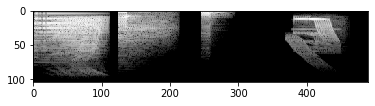

GroundTruth:  stacks        snare         kick        stacks


In [260]:
dataiter = iter(test_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '        '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))


In [261]:
#io calculator
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    print(output)
    return(output)
#get all targets


In [262]:
# let's get the weight of the samples incase we want to make a weighted
# sampler to deal with data imbalance
# # expensive to compute so commented
targets=[]
for batch_idx, (d, l) in enumerate(train_loader):
    targets.extend(list(l.numpy()))
# Compute samples weight (each sample should get its own weight)
target=torch.tensor(targets)
class_sample_count = torch.tensor(
    [(target == t).sum() for t in torch.unique(target, sorted=True)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in target])
print("here are the weights to account for class sizes")
print(dict(zip(classes,list(weight.numpy()*1000))))

here are the weights to account for class sizes
{'clap': 2.7027028, 'hat': 0.58377117, 'kick': 0.9910803, 'snare': 0.80775446, 'stacks': 0.2247191}


In [263]:
class LSTM2(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM2, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.layer_dim = layer_dim
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
class LSTM1(nn.Module):
    def __init__(self, input_dim,hidden_dim, n_layers,output_size, drop_prob=0.5):
        super(LSTM1, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
#         self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        x=x.view(-1, seq_dim, input_dim).requires_grad_()
#         batch_size = x.size(0)
        out, hidden = self.lstm(x, hidden)
#         lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         out = self.dropout(lstm_out)
        out = self.fc(out[:, -1, :])
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [264]:
##LSTM1####
batch_size=BATCH_SIZE
input_dim = 120
seq_dim=100
output_size = weight.size()[0]
hidden_dim = 500
n_layers = 4


model = LSTM1(input_dim, hidden_dim, n_layers,output_size,)
try:
    state='.models//lstm/state_dict%d-%d.pt'%(n_layers,hidden_dim)
    model.load_state_dict(torch.load(state))
except:
    print("state cannot be loaded")
model.to(device)

lr=0.005

criterion = nn.CrossEntropyLoss(weight=weight.to(device))
# criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

epochs = 10
counter = 0
print_every = 200
clip = 5
valid_loss_min = 0.4
model.train()
for i in range(epochs):
    for inputs, labels in train_loader:
        counter += 1
        h = model.init_hidden(inputs.size()[0])
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        # Get predictions from the maximum value
        _, predicted = torch.max(output.data, 1)

#         print(predicted.squeeze(), labels.float())
#         print(predicted, labels,"sdaf")
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
#             print(predicted,labels)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = model.init_hidden(inp.size()[0])
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab)
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), '.models/lstm/state_dict%d-%d.pt'%(n_layers,hidden_dim))
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)


Epoch: 1/10... Step: 200... Loss: 0.294279... Val Loss: 0.627574
Validation loss decreased (1.000000 --> 0.627574).  Saving model ...
Epoch: 1/10... Step: 400... Loss: 0.643297... Val Loss: 0.616760
Validation loss decreased (0.627574 --> 0.616760).  Saving model ...
Epoch: 1/10... Step: 600... Loss: 0.804488... Val Loss: 0.757043
Epoch: 1/10... Step: 800... Loss: 1.423251... Val Loss: 0.600763
Validation loss decreased (0.616760 --> 0.600763).  Saving model ...
Epoch: 1/10... Step: 1000... Loss: 0.609672... Val Loss: 0.826377
Epoch: 1/10... Step: 1200... Loss: 0.302356... Val Loss: 0.811988
Epoch: 1/10... Step: 1400... Loss: 0.525968... Val Loss: 0.590541
Validation loss decreased (0.600763 --> 0.590541).  Saving model ...
Epoch: 1/10... Step: 1600... Loss: 0.844825... Val Loss: 0.624157
Epoch: 1/10... Step: 1800... Loss: 0.836840... Val Loss: 0.617832
Epoch: 1/10... Step: 2000... Loss: 0.225199... Val Loss: 0.708566
Epoch: 2/10... Step: 2200... Loss: 0.690750... Val Loss: 0.584628
Va

In [ ]:
batch_size = 4
n_iters = 3000
num_epochs = n_iters 
num_epochs = int(num_epochs)

'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 120
hidden_dim = 200
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 5
# Number of steps to unroll
seq_dim = 100

model = LSTM2(input_dim, hidden_dim, layer_dim, output_dim)

# JUST PRINTING MODEL & PARAMETERS 
# print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()

'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        print(predicted, labels)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images to a Torch Variable
                images = images.view(-1, seq_dim, input_dim).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


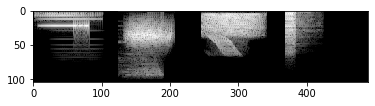

GroundTruth:  stacks        stacks        stacks          hat
torch.Size([4, 5]) tensor([4, 4, 4, 2], device='cuda:0')
Predicted:    stacks        stacks        stacks         kick


In [266]:
import torch.utils.data as data
test_size=4
testing_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
testing_loader  = data.DataLoader(testing_data, batch_size=test_size, shuffle=True, num_workers=4)
mod= LSTM1(input_dim, hidden_dim, n_layers,output_size)
state_path='./state_dict%d-%d.pt'%(n_layers,hidden_dim)
mod.load_state_dict(torch.load(state_path))
h = mod.init_hidden(test_size)
mod.to(device)

dataiter = iter(test_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '        '.join('%5s' % classes[labels[j]] for j in range(test_size)))

inputs, labels = images.to(device), labels.to(device)
output, h = mod(inputs, h)
_, predicted = torch.max(output.data, 1)
print(output.size(),predicted)
print('Predicted:   ', '        '.join('%5s' % classes[predicted[j]]
                              for j in range(test_size)))

In [268]:
correct = 0
total = 0
with torch.no_grad():
    for d in test_loader:
        images, labels =  d[0].to(device), d[1].to(device)
        h = model.init_hidden(images.size()[0])
        outputs,h = mod(images,h)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 83 %


In [269]:
class_correct = list(0. for i in range(19))
class_total = list(0. for i in range(19))

with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        h = model.init_hidden(images.size()[0])
        outputs,h = mod(images,h)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            try:
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            except:
                continue

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  clap : 45 %
Accuracy of   hat : 66 %
Accuracy of  kick : 93 %
Accuracy of snare : 57 %
Accuracy of stacks : 98 %


(5.0, 0.0)

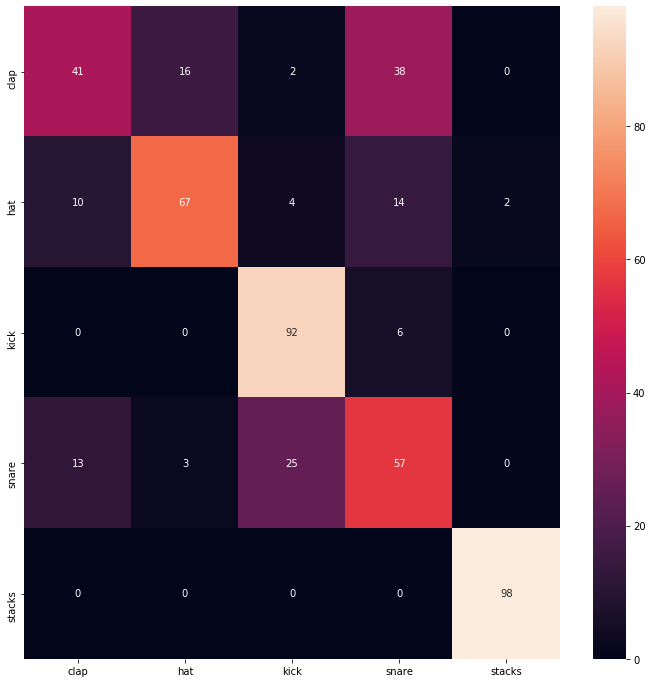

In [270]:
## making a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# plt.show() # ta-da!


predictions=[]
l=[]
with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        h = model.init_hidden(images.size()[0])
        outputs,h = mod(images,h)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())
cm=confusion_matrix(l,predictions)

# normalize confusion matrix per class
for i,c in enumerate(cm):
    cm[i]=c/sum(c)*100


df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (12,12))
sn.heatmap(df_cm, annot=True)
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values